In [1]:
import torch, torchattacks
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

Step 1: Load three different pretrained models from PyTorch. There are several pretrained models available.

In [2]:
torch.hub.set_dir("models")
resnet50 = torch.hub.load("pytorch/vision", model="resnet50", weights="ResNet50_Weights.IMAGENET1K_V1")
alexnet  = torch.hub.load("pytorch/vision", model="alexnet",  weights="AlexNet_Weights.IMAGENET1K_V1")
squeeze      = torch.hub.load("pytorch/vision", model="squeezenet1_1", weights="SqueezeNet1_1_Weights.IMAGENET1K_V1")
model_names = ['resnet50','alexnet','squeeze']

Using cache found in models/pytorch_vision_main
Using cache found in models/pytorch_vision_main
Using cache found in models/pytorch_vision_main


Step 2: In class we discussed a few adversarial attack techniques such as PGD, FGSM, etc.

torchattacks is a framework which lets you attack any model with many such adversarial attack techniques. Install torchattacks and then use it to attack your loaded model with 3 different attack techniques.

In [3]:
# https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageNet.html
# https://image-net.org/challenges/LSVRC/2012/2012-downloads.php
NUM_IMAGES = 100
dataset = datasets.ImageNet(root = "data", split = 'val', transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
limited_dataset = []
for i in range(NUM_IMAGES): limited_dataset.append(dataset[i])
dataloader = torch.utils.data.DataLoader(limited_dataset, batch_size=1, shuffle=False)

In [4]:
# https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html
# https://github.com/Harry24k/adversarial-attacks-pytorch
def get_adv_images(attk: torchattacks.AutoAttack, target_label: int) -> list[torch.Tensor]:
    X_ADV = []
    y_target = torch.tensor([target_label]).cuda()

    attk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    attk.set_mode_targeted_by_label(quiet=True)

    for x, y in dataloader:
        x = x.cuda()
        x_adv = attk(x, y_target)
        X_ADV.append(x_adv)
    return X_ADV

In [5]:
adv_images = {}

for model_idx, model in enumerate([resnet50, alexnet, squeeze]):
    adv_images[model_idx] = [[],[],[]]
    model = model.cuda()
    model.eval()

    attk_PGD  = torchattacks.PGD (model, eps=8/255, alpha=1/255, steps=10, random_start=True)
    attk_FGSM = torchattacks.FGSM(model, eps=8/255)
    attk_CW   = torchattacks.CW  (model, c=1, kappa=0, steps=50, lr=0.01)

    for attk_idx, attk in enumerate([attk_PGD, attk_FGSM, attk_CW]):
        adv_images[model_idx][attk_idx] = get_adv_images(attk, 579)

Step 3: Report accuracy in a 3×3 table (3 rows for models and 3 columns for attack techniques)

In [6]:
print(f"{'':^10}{'PGD':^10}{'FGSM':^10}{'CW':^10}")

with torch.no_grad():
    for model_idx, model in enumerate([resnet50, alexnet, squeeze]):
        print(f"{model_names[model_idx]:<10}",end='')
        for attk_idx in range(3):

            num_correct = 0.0
            for image_idx, (images, label) in enumerate(dataloader):
                pred_label = model( adv_images[model_idx][attk_idx][image_idx] ).argmax(dim=1)
                num_correct += (pred_label == label.cuda()).item()
            accuracy = f"{100*(num_correct/len(dataloader)):.0f}%"
            print(f"{accuracy:^10}", end='')
        
        print()

             PGD       FGSM       CW    
resnet50      1%       31%       40%    
alexnet       0%        5%       33%    
squeeze       0%        0%        1%    


Step 4: Choose any image of your choice and show the corresponding adversarial images generated by each attack technique from Step 2. 

For each adversarial image, report the average mean-squared error between the original image and the adversariaal image.

In [7]:
def imshow(ax: plt.Axes, x: torch.Tensor, title: str = None):
    x = x.cpu().permute(1,2,0)
    x = x * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    if(title): ax.set_title(title)
    ax.axis("off")
    ax.imshow(x)

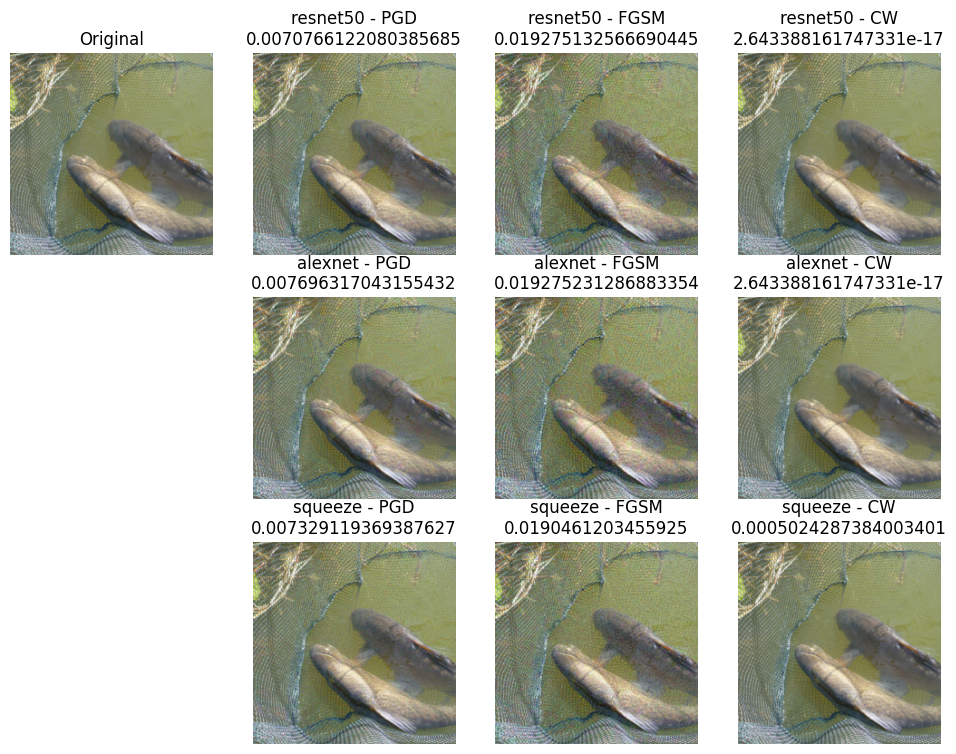

In [8]:
criterion = torch.nn.MSELoss()
img = dataset[0][0].cuda()

fig, ax = plt.subplots(3, 4, figsize=(12,9))
imshow(ax[0][0], img, "Original")
ax[1][0].set_visible(False)
ax[2][0].set_visible(False)
with torch.no_grad():
    for model_idx in range(3):
        for attk_idx, attk_name in enumerate(['PGD','FGSM','CW']):
            adv_img = adv_images[model_idx][attk_idx][0].squeeze()
            loss = criterion(adv_img, img)
            imshow(ax[model_idx][attk_idx+1], adv_img, f"{model_names[model_idx]} - {attk_name}\n{loss}")